# Data Science Project

## Purpose
The goal of this data science project is to compute the Soil Organic Carbon (SOC) stock change by land cover class within a given region. The project will be implemented using a project-based learning approach, gradually buildind a Streamlit application as the final deliverable. The application will provide an interface to visualize and analyze the SOC stock change based on land cover types.

## Methodology
The steps to follow are described in the [Data Science Project repo](https://github.com/Vizzuality/sci_team_data_bank/wiki/Data-Science-Project).

## Setup
### Library import
We import all the required Python libraries

In [1]:
import sys

import ee

import color_palettes as color
import utils

In [2]:
sys.path.append("../src")  # Add the 'src' folder to the sys.path

### Autenticate and Initialize Earth Engine

In [4]:
# ee.Authenticate()
ee.Initialize()

### Download the data from the [original source](http://maps.elie.ucl.ac.be/CCI/viewer/), convert NETCDF into GeoTIFF and upload it to Google Earth Engine

This only needs to be done once. And **note** that method upload_to_gee doesn't work because we can't upload files from local to GEE, they have to be stored in a bucket in Google Cloud Storage. Thus, we need to upload them manually. 


In [5]:
# input_nc_files = [
#     "/Users/sofia/Documents/Repos/SciVizz_project/data/raw/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc", # noqa: E501
#     "/Users/sofia/Documents/Repos/SciVizz_project/data/raw/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.nc" # noqa: E501
# ]
# output_tif_files = [
#     "/Users/sofia/Documents/Repos/SciVizz_project/data/processed/landcover2000.tif",
#     "/Users/sofia/Documents/Repos/SciVizz_project/data/processed/landcover2018.tif"
# ]

# # Convert the NetCDF files to GeoTIFF
# data_processor = LandcoverDataProcessor(input_nc_files, output_tif_files)
# data_processor.convert_nc_to_tif()

# # Create a collection in GEE and upload the GeoTIFF files
# collection_path = "projects/ee-sofiaaldabet-training/assets/landcover"
# data_processor.create_gee_collection(collection_path)
# data_processor.upload_to_gee()

## Processing

### Display the map 

1. Calculate SOC stock change and visualize it together with the land cover layers for 2000 and 2018. 

2. Include the functionality to draw custom geometries on the map for further analysis.

In [6]:
# Create instances of MapRenderer, GeometryDrawer, and LandcoverAnalyzer
map_renderer = utils.MapRenderer(center=(42, -8), zoom=7)
geometry_drawer = utils.GeometryDrawer(map_renderer)
landcover_analyzer = utils.LandcoverAnalyzer(map_renderer)

# Create instances of the GEEImageLoader
soc_stock_collection = "projects/soils-revealed/Recent/SOC_stock_nov2020"
lc_collection = "projects/ee-sofiaaldabet-training/assets/landcover"
soc_loader = utils.GEEImageLoader(soc_stock_collection)
lc_loader = utils.GEEImageLoader(lc_collection)

# Get the first and last images for SOC stock and calculate the difference
first_image, last_image = soc_loader.get_first_and_last_images()
soc_stock_change = last_image.subtract(first_image)

# Define the visualization parameters for SOC stock change
soc_vis_params = {"min": -10, "max": 10, "palette": color.soc_color_ramp}

# Load landcover images filtering by date
lc1 = lc_loader.select_images_by_date("2000-01-01", "2000-12-31")
lc2 = lc_loader.select_images_by_date("2018-01-01", "2018-12-31")

# Add the layers to the map
map_renderer.add_tile_layer(soc_stock_change, soc_vis_params, name="SOC Stock Change")
map_renderer.add_tile_layer(lc1, None, color.sld_ramp, name="Landcover 2000")
map_renderer.add_tile_layer(lc2, None, color.sld_ramp, name="Landcover 2018")

# Display the map
map_renderer.display()

Map(center=[42, -8], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

### Calculate statistics for an Area Of Interest (AOI):

1. Define the AOI or AOIs on the map
2. Calculate the % for each landcover in the AOI
3. Visualize the results in a chart

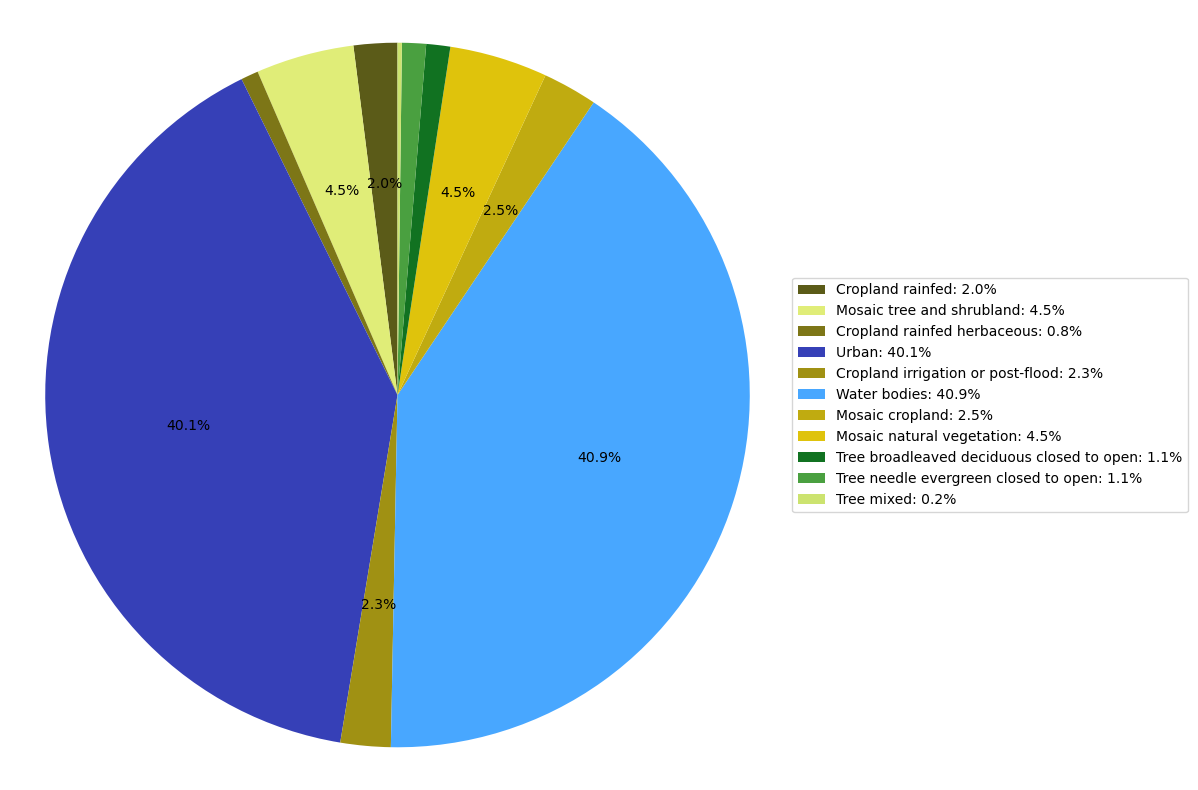

In [7]:
# Analyze land cover using the LandcoverAnalyzer
result_df = landcover_analyzer.analyze_landcover(
    image_collection="projects/ee-sofiaaldabet-training/assets/landcover",
    start_date="2018-01-01",
    end_date="2018-12-31",
    landcover_info=color.landcover_info,
    geometries=geometry_drawer.get_drawn_geometries(),
)
# Display the result in a pie chart
landcover_analyzer.plot_landcover_pie_chart(result_df)